# Лекция 12: Map-Reduce

__Автор: Сергей Вячеславович Макрушин, 2022 г.__

e-mail: s-makrushin@yandex.ru

v 0.3 11.12.2022

## Разделы: <a class="anchor" id="разделы"></a>
* [Map / Filter / Reduce](#map_reduce)
* [Dask Bag](#bag)
    * [Знакомство с Dask Bag](#bag_intro)
    * [Создание Dask Bag и введение в API](#bag_create)
    * [API Dask.Bag](#bag_map)
    * [Функции маппинга для Dask Bag](#bag_api)    
    * [Функции преобразования строк в Dask Bag](#bag_str)    
    * [Функции фильтрации в Dask Bag](#bag_filter)
    * [Функции преобразующие Dask Bag](#bag_proc)
    * [Функции ггруппировки, свертки и агрегации в Dask Bag](#bag_shuffle)
* [Пример обработки данных с помощью Dask Bag](#bag_example)

-

* [к оглавлению](#разделы)

In [133]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

## Map / Filter / Reduce <a class="anchor" id="map_reduce"></a>
-
* [к оглавлению](#разделы)

<center>         
    <img src="./img/MFR_emj.png" alt="Иллюстрация концепции Map / Filter / Reduce" style="width: 500px;"/>
    <b>Иллюстрация концепции Map / Filter / Reduce</b>
</center>

### Map

<center>         
    <img src="./img/map_.jpg" alt="Работа функции map()" style="width: 700px;"/>
    <b>Работа функции map()</b>
</center>

Встроенная функция `map() `позволяет применить функцию к каждому элементу последовательности
* Функция имеет следующий формат: `mар(<Функция>, <Последовательность1>[, ... , <ПоследовательностьN>])`

* Функция возвращает объект, nоддерживающий итерацию, а не сnисок.

#### Map: пример 1

In [153]:
squared = lambda x: x**2

In [154]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [157]:
m1 = map(squared, range(10)) # второй аргумент - итерируемый объект!
m1 # map реализует принцип ленивых вычислений

In [158]:
# for e in m1:
#     print(e)

In [159]:
list(m1)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

#### Map: пример 2

In [160]:
ls0 = list(zip(range(10), range(0, 100, 10)))
ls0

[(0, 0),
 (1, 10),
 (2, 20),
 (3, 30),
 (4, 40),
 (5, 50),
 (6, 60),
 (7, 70),
 (8, 80),
 (9, 90)]

In [161]:
import operator as op

In [162]:
op.add(2, 3)

5

In [163]:
op.add((2, 3))

TypeError: add expected 2 arguments, got 1

In [164]:
op.add(*(2, 3))

5

применение функции, принимающей несколько параметров:

In [165]:
list(map(op.add, ls0)) # ошибка, неверное количество параметров!

TypeError: add expected 2 arguments, got 1

In [166]:
# 1й способ:
def my_add(par):
    return op.add(*par)

In [167]:
list(map(my_add, ls0)) 

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [79]:
# 2й способ:

from itertools import starmap
# starmap вычисляет значение функции для аргументов сгруппированных в итерируемом объекте (втром параметре)

In [168]:
list(starmap(op.add, ls0))

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

#### Map: пример 3

<center>         
    <img src="./img/map2_.jpg" alt="Работа функции map() с несколькими итерируемыми объектами" style="width: 700px;"/>
    <b>Работа функции map() с несколькими итерируемыми объектами</b>
</center>

Функции map() можно nередать несколько nоследовательностей. В этом случае в функцию 
обратного вызова будут nередаваться сразу несколько элементов, расnоложенных в nоследовательностях на одинаковом смещении. 

In [169]:
ls1 = list(range(10))
ls2 = list(range(0, 100, 10))
ls3 = list(range(0, 1000, 100))

In [170]:
ls1, ls2, ls3

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 [0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [171]:
list(map(op.add, ls1, ls2))

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [172]:
list(map(lambda x, y, z: x+10*y+100*z, ls1, ls2, ls3))

[0, 10101, 20202, 30303, 40404, 50505, 60606, 70707, 80808, 90909]

### Filter

<center>         
    <img src="./img/filter_.jpg" alt="Работа функции filter()" style="width: 700px;"/>
    <b>Работа функции filter()</b>
</center>

Функция `filter()` nозволяет выnолнить nроверку элементов nоследовательности. 
* Формат функции: `filtеr(<Функция>, <Последовательность>)`
* Если в nервом nараметре вместо названия функции указать значение `None`, то каждый элемент nоследонательности будет nроверен на соответствие булевскому значению True.
* Если элемент в логическом контексте возвращает значение False, то он не будет добавлен в возвращаемый результат. 
* Функция возвращает объект, nоддерживающий итерацию, а не сnисок.

In [173]:
import random
random.seed(42)

In [174]:
lr1 = [random.randint(-100, 100) for i in range(20)]
lr1

[63,
 -72,
 -94,
 89,
 -30,
 -38,
 -43,
 -65,
 88,
 -74,
 73,
 89,
 39,
 -78,
 51,
 8,
 -92,
 -93,
 -77,
 -45]

In [175]:
list(filter(lambda x: x%3 == 0, lr1))

[63, -72, -30, 39, -78, 51, -93, -45]

In [176]:
# аналог генератор списков:
[i for i in lr1 if i%3==0]

[63, -72, -30, 39, -78, 51, -93, -45]

In [177]:
lr2 = [random.randint(-1, 1) for i in range(20)]
lr2

[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 0, -1, 0, 1, 0, -1, -1, 1, 0, 0]

In [178]:
# первый параметр None имеет особую семантику:
list(filter(None, lr2))

[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1]

In [179]:
filter(lambda x: x%3 == 0, lr1)

In [180]:
map(op.abs, filter(lambda x: x%3 == 0, lr1))

In [181]:
# последовательное примененеие преобразований:
list(map(op.abs, filter(lambda x: x%3 == 0, lr1)))

[63, 72, 30, 39, 78, 51, 93, 45]

In [182]:
%%timeit
[i for i in lr1 if i%3==0]

3.59 µs ± 754 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [183]:
%%timeit
list(filter(lambda x: x%3 == 0, lr1))

4.22 µs ± 473 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Reduce

In [184]:
import functools

In [185]:
from functools import reduce

`functools.reduce(funct, iterable[, initializer])`

Вычисляет функцию от двух элементов последовательно для элементов последовательности слева направо таким образом, что результатом вычисления становится единственное значение, которое становится первым аргументом для следующей итерации применения `funct`. 

In [186]:
# Пример: 
reduce(lambda x, y: x + y, [1, 2, 3, 4, 5]) # вычисляется как ((((1+2)+3)+4)+5)

15

Левый аргумент функции `funct` (аргумента `reduce`) - это аккумулированное значение, правый аргумент - очередное значение из списка.

Если передан необязательный аргумент `initializer`, то он используется в качестве левого аргумента при первом применении 
функции (исходного аккумулированного значения).

Если `initializer` не перередан, а последовательность имеет только одно значение, то возвращается это значенние.

<center>         
    <img src="./img/reduce_.jpg" alt="Работа функции reduce()" style="width: 700px;"/>
    <b>Работа функции reduce()</b>
</center>

In [187]:
ls4 = list(range(10, 20))
ls4

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [188]:
reduce(op.add, ls4)

145

In [189]:
reduce(op.add, range(10, 20))

145

In [190]:
def add_verbose(x, y):
    print(f"add(x={x}, y={y}) -> {x+y}")
    return x + y

In [192]:
reduce(add_verbose, ls4)

add(x=10, y=11) -> 21
add(x=21, y=12) -> 33
add(x=33, y=13) -> 46
add(x=46, y=14) -> 60
add(x=60, y=15) -> 75
add(x=75, y=16) -> 91
add(x=91, y=17) -> 108
add(x=108, y=18) -> 126
add(x=126, y=19) -> 145


145

In [193]:
reduce(add_verbose, ls4, 1000)

add(x=1000, y=10) -> 1010
add(x=1010, y=11) -> 1021
add(x=1021, y=12) -> 1033
add(x=1033, y=13) -> 1046
add(x=1046, y=14) -> 1060
add(x=1060, y=15) -> 1075
add(x=1075, y=16) -> 1091
add(x=1091, y=17) -> 1108
add(x=1108, y=18) -> 1126
add(x=1126, y=19) -> 1145


1145

In [194]:
st = "This is a test.".split()
st

['This', 'is', 'a', 'test.']

In [195]:
def f2(n, s):
    print(f'n: {n}, s: {s}, len(s): {len(s)}')
    return n + len(s)

In [196]:
# Ошибка:
reduce(f2, ['This', 'is', 'a', 'test.']) 

n: This, s: is, len(s): 2


TypeError: can only concatenate str (not "int") to str

In [97]:
reduce(f2, ['This', 'is', 'a', 'test.'], 0) 

n: 0, s: This, len(s): 4
n: 4, s: is, len(s): 2
n: 6, s: a, len(s): 1
n: 7, s: test., len(s): 5


12

In [197]:
reduce(lambda n, s: n + len(s), "This is a test.".split(), 0) 

12

In [198]:
reduce(lambda n, s: n + list(s), "This is a test.".split(), []) 

['T', 'h', 'i', 's', 'i', 's', 'a', 't', 'e', 's', 't', '.']

## Dask Bag <a class="anchor" id="bag"></a> 
-
* [к оглавлению](#bag)

### Знакомство с Dask Bag <a class="anchor" id="bag_intro"></a> 
-
* [к оглавлению](#разделы)

__Структура данных Bag__

<em class="df"></em> __Мультимножество (bag, multiset)__ в математике - обобщение понятия множества, допускающее включение одного и того же элемента по нескольку раз. Число элементов в мультимножестве, с учётом повторяющихся элементов, называется его размером или мощностью.

* `list`: упорядоченная коллекция, допускающая повторы элементв.
    * Пример: `[1, 2, 3, 2]`
* `set`: неупорядоченная коллекция, не допускающая повторы элементов.
    * Пример: `{3, 1, 2}` (эквиваленто `{1, 2, 3}`, данный вариант `{1, 2, 2, 3}` автоматически перобразуется к `{1, 2, 3}`)
* `bag`: неупорядоченная коллекция, допускающая повторы элементов. 
    * Пример: `bag(1, 2, 2, 3)` (эквивалентно `bag(2, 1, 2, 3)`)

Таким образом, bag можно рассматривать как __список, не гарантирующий порядка элементов__.

__Dask.Bag__

`Dask.Bag` реализует такие операции, как `map`, `filter`, `fold` (аналог `reduce`) и `groupby` над коллекциями объектов Python. 

Реализация `Dask.Bag` основана на координации множества списков или итераторов, каждый из которых представляет собой сегмент (partition) большой коллекции. Данная реализация обеспечивает: 
* параллельное выполнение операций 
* потребность в небольшом объеме памяти за счет использования итераторов Python и __ленивых вычислений__. Это обеспечивает возможность обработки данных больших чем объем оперативной памяти, даже при использовании всего одного сегмента.


<em class="df"></em> __Ленивые вычисления__ (lazy evaluation, или отложенные вычисления) — стратегия вычислений, согласно которой вычисления откладываются до тех пор, пока не понадобится их результат.

Аналоги:
* `Dask.Bag` можно считать параллельной реализацией пакета `PyToolz` 
* Или ориентированной на Python версией `PySpark RDD` (интерфейса для работы в Python с ключевой структурой данных Spark - RDD).

__Типичное использование Dask.Bag__

`Dask.Bag` хорошо подходит для распараллеливания __простой обработки неструктурированных или полу-структурированных данных__, таких как:
* текстовые данные
* файлы логирования
* записи в формате JSON
* специальных oбектов Python и т.д. 


* Если выполнение задачи возможно при помощи `Dask.DataFrame` или `Dask.Array`, то __стоит выбрать этии варианты__, так как основной объем вычислений будет выполняться за счет __быстрых библиотек написанных на компилируемых языках__, тогда как `Dask.Bag` использует только код на Python. 
* __Приемуществами__ `Dask.Bag` является:
    * возможность использовать __любые пользовательские функции__ написанные на Python
    * существенно __меньшие требования__ к наличию __строгой структуры__ у обрабатываемых данных.

__Специфика реализации__

По умолчанию, `Dask.Bag` использует для исполнения __планировщик__ `dask.multiprocessing`.
* <em class="pl"></em> Это позволяет __обойти проблему GIL__ и полноценно использовать несколько процессорных ядер для объектов реализованных на чситом Python.
* <em class="mn"></em> Минусом этого подходя является наличие больших накладных расходов при обмене данных между исполнителями, что важно для производительности вычислений, требующих интенсивного обмена данными. Это редко бывает проблемой, так как типичный поток задач для `Dask.Bag` подразумевает:
    * или __черезвычайно параллельные вычисления__ 
    * или обмен небольшим объемом данных в процессе __свертки__ (англ. folding, также известна как reduce, accumulate).

<em class="df"></em> __Чрезвычайная параллельность__ (embarrassingly parallel) - тип задач в системах параллельных вычислений, для которых не требуется прилагать больших усилий при разделении на несколько отдельных параллельных задач (распараллеливании).
* Чаще всего __не существует зависимости (или связи) между  параллельными задачами__, то есть их результаты не влияют друг на друга.
* Чрезвычайно параллельные задачи __практически не требуют согласования__ между результатами выполнения отдельных этапов, что отличает их от задач распределённых вычислений, которые требуют связи промежуточных результатов.
* Такие задачи __легки для исполнения массово паралельных системах__ (кластерах с очень большим количеством вычислительных узлов).

__Модель вычислений MapReduce для обработки больших данных__

<br/>
<center>         
    <img src="./img/MSR.png" alt="Распространенность использования Dask" style="width: 600px;"/>
    <b>Принцип работы MapReduce</b>
</center>

__MapReduce__ — модель распределённых вычислений, представленная компанией Google, используемая для параллельных вычислений над очень большими (до нескольких петабайт) наборами данных. Для этого используется большое количества соединенных сетью компьютеров (называемых __«ноды»__), вместе образующих __кластер__.


Фреймворк MapReduce обычно включает три шага обработки данных:
* На шаге __Map__ (назван по аналогии с функцией высшего порядка `map()`) выполняется предварительная обработка входных данных - главный узел кластера (master node) получает этот список, делит его на части и передает рабочим узлам (worker node). Далее каждый рабочий узел применяет функцию Map к локальным данным и записывает результат в формате «ключ-значение» во временное хранилище.
* На шаге __Shuffle__ выполняется "перемешивание" рабочие узлы перераспределяют данные на основе выходных ключей (создаваемых функцией map()), так чтобы все данные, относящиеся к одному ключу лежали на одном рабочем узле.
* На шаге __Reduce__ выполняется параллельная обработка каждым рабочим узлом каждой группы данных по порядку следования ключей и «склейка» результатов на главном узле. 
* Далее главный узел получает промежуточные ответы от рабочих узлов и передаёт их на свободные узлы для выполнения следующего шага. Получившийся после прохождения всех необходимых шагов результат – это и есть решение исходной задачи.

<center>         
    <img src="./img/MSR2.png" alt="Распространенность использования Dask" style="width: 800px;"/>
    <b>Принцип работы MapReduce</b>
</center>

Преимущество MapReduce заключается в том, что он позволяет распределенно производить операции предварительной обработки и свертки.

В модели вычислений MapReduce шаг __"перемешивания" (shuffle)__, отвечающий за __группировку данных__, требует __интенсивного обмена данными__ между исполнителями.
* Например, шаг __группировки (перемешивания)__ выполняется при выполнении операции `Dask.Bag` `groupby`.
* __Операция группировки очень ресурсоемкая__ и эффективнее выполняется при помощи `Dask.DataFrame` или `Dask.Array`. Поэтму предпочтительнее использовать `Dask.Bag` для подготовки и структурирования данных, а для выполнения более сложных операций преобразовывать их в `Dask.DataFrame`.

__Ограничения Dask.Bag__

Dask.Bag позволяет выполнять любую функцию на Python, эта универсальность имеет свою цену. Dask.Bag имеет следующие ограничения:
* По умолчанию обработка Dask.Bag __выполняется планировщиком, на базе multiprocessing__, что создает ряд ограничений.
* Bag яляется __неизменяемой структурой данных__, таким образом нет возможности изменить единичный элемент Dask.Bag не выполнив операцию преобразования для всей структуры данных.
* Операции над Bag __медленнее__, чем операции над __Array/DataFrame__ по тем же причинам, по которым операции на Python медленнее чем аналогичные операции в NumPy и Pandas.
* Операция __Bag.groupby выполняется медленно__, по возможности нужно использовать вместо нее Bag.foldby или преобразовывать данные в структуру DataFrame.

### Создание Dask Bag <a class="anchor" id="bag_create"></a> 
-
* [к оглавлению](#разделы)

`Bag` можно создать из последовательности (итерируемого объекта) Python, из файла (файлов) и т.п. Данные в `Bag` разбиваются на сегменты (блоки), каждый из которых содержит множество элементов исходного набора данных.

In [199]:
import dask.bag as db

In [200]:
# набор данных (list - итерируемый объект Python) из целых чисел
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2) # разбиваем последовательность на 2 сегмента
b.take(3) # выводит 3 элемента из Bag

(1, 2, 3)

In [202]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b

dask.bag<from_sequence, npartitions=10>

Через параметр `npartitions` можно управлять разбиением данных на сегменты (partitions). По умолчанию Dask пытается разбить данные на количество сегментов, близкое к 100.

Функция `read_text` может принимать на вход файл или последовательность файлов:

```python
>>> b = db.read_text('myfile.txt')
>>> b = db.read_text(['myfile.1.txt', 'myfile.2.txt', ...])
>>> b = db.read_text('myfile.*.txt')
```

* Функция умеет использовать стандартные форматы архивов, такие как gzip, bz2, xz (могут быть подключены и другие форматы).

* Элементами в созданном Bag будут строки переданных текстовых файлов. По умолчанию каждый сегмент Bag будет относится к одному файлу (при помощи параметров files_per_partition и blocksize можно управлять разбиением на сегменты). 

* __Не загружайте данные предназначенные для Bag предварительно__, используйте для этого только функции Bag. Это позволит избежать нераспараллеленного участка работ и загрузки всего массива данных в память. Если для используемого формата данных нет стандартного загрузчика - исползуйте следующий подход:

```python
>>> # load_from_filename - пользовательская функция загрузки данных
>>> b = db.from_sequence(['1.dat', '2.dat', ...]).map(load_from_filename)
```

In [5]:
# Генерация данных (нужно создать папку ./data)
# скрипты для генерации (в т.ч. prep.py лежат в текущей папке)
%run prep.py -d accounts

In [203]:
# данные загружаются из набора заархивированных файлов формата JSON
# элементами Bag будут строки файлов, сегментация будет проведена по файлам
data_path = './data'
import os
b = db.read_text(os.path.join(data_path, 'accounts.*.json.gz'))
b.take(1)

('{"id": 0, "name": "Frank", "transactions": [{"transaction-id": 1341, "amount": 289}, {"transaction-id": 3824, "amount": 240}, {"transaction-id": 5168, "amount": 235}, {"transaction-id": 7303, "amount": 250}, {"transaction-id": 7580, "amount": 283}, {"transaction-id": 9440, "amount": 169}, {"transaction-id": 9660, "amount": 127}, {"transaction-id": 10265, "amount": 247}, {"transaction-id": 10680, "amount": 171}, {"transaction-id": 10864, "amount": 142}, {"transaction-id": 11473, "amount": 183}, {"transaction-id": 12037, "amount": 203}, {"transaction-id": 12272, "amount": 206}, {"transaction-id": 12767, "amount": 156}, {"transaction-id": 13008, "amount": 195}, {"transaction-id": 13233, "amount": 162}, {"transaction-id": 13614, "amount": 197}, {"transaction-id": 14379, "amount": 240}, {"transaction-id": 15409, "amount": 313}, {"transaction-id": 16717, "amount": 162}, {"transaction-id": 16873, "amount": 221}, {"transaction-id": 19635, "amount": 162}, {"transaction-id": 21944, "amount": 1

In [204]:
b.npartitions

50

### API Dask.Bag <a class="anchor" id="bag_api"></a> 
-
* [к оглавлению](#разделы)

Объекты Bag поддерживают стандартное API, аналогичное имеющемуся в стандартной библиотеке Python и библиотеках toolz или pyspark. В частности, имеются функции, отвечающие за:
* __мэппинг__ (map и т.п.)
* __фильтрацию и группировку__ (filter, groupby и т.п.)
* __свертку__ (reduce и т.п.).

Документация по API Dask.Bag : https://docs.dask.org/en/latest/bag-api.html 

In [205]:
def is_even(n):
    return n % 2 == 0

b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], npartitions=4)
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=4>

* Операции над объектом Bag, создают новые объекты Bag, таким образом формируются задачи для отоложенных вычислений. 
* Для старта вычислений необходимо вызвать для объекта Bag функцию `compute()`.
    * Результат `compute()` для объектов Bag будет представлен в виде списка (или единичного значения при операциях свертки).
    * Получение итератора по bag приводит к выполнению `compute()`. Таким образмом `list(bag)` автоматически стартует вычисления.

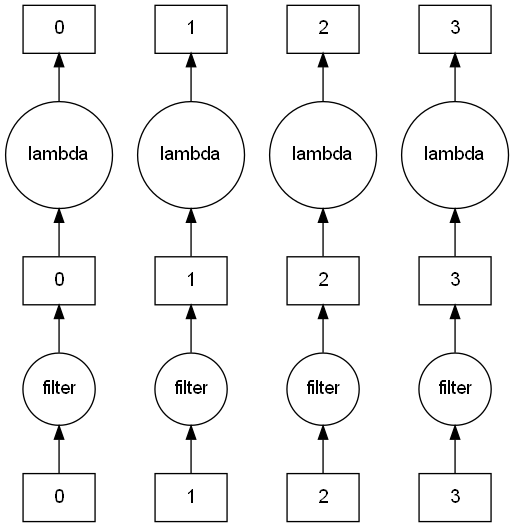

In [206]:
c.visualize()

In [207]:
# вызов compute() синхронный: возрват из функции происхоит только после получения всех результатов
c.compute()

[4, 16, 36, 64, 100, 144]

In [208]:
list(b.filter(is_even).map(lambda x: x ** 2))

[4, 16, 36, 64, 100, 144]

Для того чтобы стартовать промежуточные вычсиления, которые приведут к созданию объекта Dask (например Bag), хранящегося в памяти (например загрузки данных из файла и их предварительной обработки) вместо `compute()` нужно вызывать функцию `persist()`. С полученным объектом Bag можно выполнять последующие операции исходя из того что предварительные операции уже выполнены и результаты уже хранятся в оперативной памяти. 

In [209]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], npartitions=4)
c = b.filter(is_even).map(lambda x: x ** 2)
p = c.persist()

In [210]:
p

dask.bag<lambda, npartitions=4>

In [211]:
m1 = p.map(lambda x: x / 3)

In [212]:
m1

dask.bag<lambda, npartitions=4>

In [213]:
list(m1)

[1.3333333333333333,
 5.333333333333333,
 12.0,
 21.333333333333332,
 33.333333333333336,
 48.0]

Если после обработки с помощью Bag получены хорошо структурированные данные, то продолжить их обработку может быть эффективнее при помощи Dask DataFrame (аналог Pandas DataFrame). Ряд операций для DataFrame реализованы существенно эффективнее, да и обычные функции, за счет вызовов откомпелированного кода Pandas, выполняются намного быстрее.

In [214]:
b = db.from_sequence([{'name': 'Alice',   'balance': 100}, 
                      {'name': 'Bob',     'balance': 200},
                      {'name': 'Charlie', 'balance': 300}], npartitions=2)
# преобразование в Dask DataFrame:
df = b.to_dataframe()
df

,name,balance
npartitions=2,,
,object,int64
,...,...
,...,...


## Функции маппинга для Dask Bag <a class="anchor" id="bag_map"></a> 
-
* [к оглавлению](#разделы)

__Функции маппинга__

Функции маппинга для DaskBag:

| Функция | Краткое описание |
|------|------|
|Bag.map(func, \*args, \*\*kwargs) | Apply a function elementwise across one or more bags|
|Bag.map_partitions(func, \*args, \*\*kwargs) | Apply a function to every partition across one or more bags|
|Bag.starmap(func, \*\*kwargs) | Apply a function using argument tuples from the given bag|
|Bag.pluck(key[, default]) | Select item from all tuples/dicts in collection|

In [215]:
import operator as op

Примеры использования функции `map`

In [216]:
b1 = db.from_sequence(range(6), npartitions=2)
b1.map(lambda x: x + 1).compute()

[1, 2, 3, 4, 5, 6]

In [217]:
b2 = db.from_sequence(range(6, 12), npartitions=2)
# после func в map могут передваться другие объекты Bag для выполнения мэппинга с несколькими мультимножествами
# все объекты Bag, участвующие в мэппинге должны быть одинаково сегментированны
b1.map(op.add, b2).compute()

[6, 8, 10, 12, 14, 16]

In [218]:
b3 = db.from_sequence([0, 3, 15]*2, npartitions=2)
# использование 3х Bag'ов в map:
b1.map(lambda *x: sum(x)/len(x), b2, b3).compute()

[2.0,
 3.6666666666666665,
 8.333333333333334,
 4.0,
 5.666666666666667,
 10.333333333333334]

In [219]:
# Дополнительные аргументы (позиционные и именованные) для func могут передваться через *args, **kwargs
# Аргументы будут транслироваться для всех вызовов func. 
# Дополнительные аргументы должны следовать после объектов типа Bag.
b1.map(op.pow, 3).compute()

[0, 1, 8, 27, 64, 125]

In [230]:
# менее удобный способ решения задачи:
b1.map(lambda x: op.pow(x, 3)).compute()

[0, 1, 8, 27, 64, 125]

Примеры использования функции `starmap`

In [222]:
# starmap применяет func к картежам аргументов из преданного на вход объекта bag
b = db.from_sequence([(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)], npartitions=2)
b.starmap(op.add).compute()

[3, 7, 11, 15, 19]

Примеры использования функции `pluck`

In [223]:
# pluck выбирает значение по ключу (индексу) из коллекции (словаря, списка, кортежа)

b = db.from_sequence([{'name': 'Alice', 'credits': [1, 2, 3]},
                      {'name': 'Bob',   'credits': [10, 20]},
                      {'name': 'Rob'}])

In [224]:
b.map(lambda x: x['name']).compute()

['Alice', 'Bob', 'Rob']

In [225]:
b.pluck('name').compute()

['Alice', 'Bob', 'Rob']

In [226]:
# использование значения по умолчанию:
b.pluck('credits', default=[-1]).compute()

[[1, 2, 3], [10, 20], [-1]]

In [227]:
# работа с bag из списков:
b = db.from_sequence([[1, 2, 3], [10, 20], [11, 7]])

In [228]:
b.map(lambda x: x[1]).compute()

[2, 20, 7]

In [229]:
b.pluck(1).compute()

[2, 20, 7]

## Функции преобразования строк в Dask Bag <a class="anchor" id="bag_str"></a> 
-
* [к оглавлению](#разделы)

__Преобразование строк__

Одиним из целвых объектов для обработки с помощью Dask Bag являются строки, поэтому для работы с ними поддержвается специализированный набор функций.
Преобразование строк для Dask Bag можно выполнять с использованием функций из пространства имен `str`.

Обработку строк, находящихся в объектах Bag, можно осуществлять используя пространство имен `str`, которое напрямую привязано к объектам Bag. Таким образом мэппинг функций из str можно производить напрямую, не исопльзуя функцию `map`.

In [231]:
b = db.from_sequence(['Alice Smith', 'Bob Jones', 'Charlie Smith'])

In [232]:
b.map(lambda x: x.lower()).compute()

['alice smith', 'bob jones', 'charlie smith']

Через `str` доступно большинство методов, применемых к объекам str в Python.

In [233]:
# вызовы методов строки:

print(b.str.lower().compute())

print(b.str.split(' ').compute())

['alice smith', 'bob jones', 'charlie smith']
[['Alice', 'Smith'], ['Bob', 'Jones'], ['Charlie', 'Smith']]


In [234]:
# не стандратная функция match, позволяющая выполнять match аналогичный re:

print(b.str.match('*Smith').compute())

['Alice Smith', 'Charlie Smith']


## Функции фильтрации в Dask Bag <a class="anchor" id="bag_filter"></a> 
-
* [к оглавлению](#разделы)

__Функции фильтрации__

| Функция | Краткое описание|
|------|------|
|Bag.filter(predicate) | Filter elements in collection by a predicate function|
|Bag.random_sample(prob[, random_state]) | Return elements from bag with probability of prob|
|Bag.remove(predicate) | Remove elements in collection that match predicate|

Примеры использования функции `filter`

In [235]:
b = db.from_sequence(range(5))
list(b.filter(lambda x: x % 2 == 0))  

[0, 2, 4]

Примеры использования функции `random_sample`

In [239]:
b = db.from_sequence(range(50), npartitions=4)
list(b.random_sample(0.1))

[18, 27, 30, 38]

Примеры использования функции `remove`

In [240]:
b = db.from_sequence(range(5))
# удаляет все элементы для которых выполняется предикат
list(b.remove(lambda x: x % 2 == 0))

[1, 3]

## Функции преобразующие Dask Bag <a class="anchor" id="bag_proc"></a> 
-
* [к оглавлению](#разделы)

__Функции, преобразующие Bag__

| Функция | Краткое описание|
|------|------|
|concat(bags) | Concatenate many bags together, unioning all elements|
|zip(\*bags) | Partition-wise bag zip|
|||
|Bag.join(other, on_self[, on_other]) | Joins collection with another collection|
|Bag.product(other) | Cartesian product between two bags|
|Bag.flatten() | Concatenate nested lists into one long list|
|Bag.repartition(npartitions) | Coalesce bag into fewer partitions|

Примеры использования функции `concat`

In [241]:
a = db.from_sequence([1, 2, 3])
b = db.from_sequence([4, 5, 6])
print(f'a.npartitions: {a.npartitions}, b.npartitions: {b.npartitions}')
c = db.concat([a, b])
print(f'c.npartitions: {c.npartitions}')
list(c)

a.npartitions: 3, b.npartitions: 3
c.npartitions: 6


[1, 2, 3, 4, 5, 6]

Примеры использования функции `zip`

In [242]:
# переданные мультимножества должны иметь одинаковое количество сегментов, 
# а количество элементов в сегментах должно совпадать
evens = db.from_sequence(range(0, 20, 2), partition_size=4)
odds = db.from_sequence(range(1, 20, 2), partition_size=4)
pairs = db.zip(evens, odds)
list(pairs)

[(0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19)]

In [243]:
evens.npartitions, pairs.npartitions

(3, 3)

Примеры использования функции `join`

In [244]:
names_l = ['Alice', 'Bob', 'Charlie', 'Robert']
people = db.from_sequence(names_l)
fruit_l = ['Apple', 'Apricot', 'Banana', 'Fig', 'Tangerine']

people.npartitions

4

In [245]:
# bag.join выполняет соединение со значениями  из итерируемого контейнера 
# по условию равенства результатов возвращаемых функцией on_self

# соединение слов равной длины:
list(people.join(fruit_l, len)) 

[('Apple', 'Alice'),
 ('Fig', 'Bob'),
 ('Apricot', 'Charlie'),
 ('Banana', 'Robert')]

In [246]:
# соединение слов, начинающихся на одинаковую букву:
list(people.join(fruit_l, lambda x: x[0])) 

[('Apple', 'Alice'), ('Apricot', 'Alice'), ('Banana', 'Bob')]

In [248]:
# соединение слов, которые в people заканичваются на букву с которой начинаются слова в fruit:
list(people.join(fruit_l, lambda x: x[-1], lambda x: x[0].lower())) 

[('Banana', 'Bob'), ('Tangerine', 'Robert')]

Примеры использования функции `product`

In [249]:
fruit = db.from_sequence(fruit_l[:3])
# возвращает bag содержащий все пары (в виде картежей) элементов исходных мультимножеств 
# элементы в картежах упорядочены согласно порядку в операции исходных мультимножест 
pp = people.product(fruit)
print(f'people.npartitions: {people.npartitions}')
list(pp)

people.npartitions: 4


[('Alice', 'Apple'),
 ('Alice', 'Apricot'),
 ('Alice', 'Banana'),
 ('Bob', 'Apple'),
 ('Bob', 'Apricot'),
 ('Bob', 'Banana'),
 ('Charlie', 'Apple'),
 ('Charlie', 'Apricot'),
 ('Charlie', 'Banana'),
 ('Robert', 'Apple'),
 ('Robert', 'Apricot'),
 ('Robert', 'Banana')]

In [250]:
pp.npartitions

12

Примеры использования функции `flatten`

In [251]:
people.map(list).compute()

[['A', 'l', 'i', 'c', 'e'],
 ['B', 'o', 'b'],
 ['C', 'h', 'a', 'r', 'l', 'i', 'e'],
 ['R', 'o', 'b', 'e', 'r', 't']]

In [252]:
people.npartitions

4

In [253]:
# конкатенирует вложнные списки в плоское (без вложенных контейнеров) мультимножество
people_flat = people.map(list).flatten()
print(people_flat.npartitions)
print(list(people_flat))

4
['A', 'l', 'i', 'c', 'e', 'B', 'o', 'b', 'C', 'h', 'a', 'r', 'l', 'i', 'e', 'R', 'o', 'b', 'e', 'r', 't']


## Функции группировки, свертки и агрегации в Dask Bag <a class="anchor" id="bag_shuffle"></a> 
-
* [к оглавлению](#разделы)

__Функции группировки (shuffle)__

| Функция | Краткое описание|
|------|------|
|Bag.groupby(grouper[, method, npartitions, …]) | Group collection by key function|
|Bag.distinct() | Distinct elements of collection|
|Bag.frequencies([split_every, sort]) | Count number of occurrences of each distinct element|\

Примеры использования функции `groupby`

In [254]:
b = db.from_sequence(range(12), npartitions=4)
# группирует значения из bag по результатам функции key
# очень ресурсоемкая операция, по возможности нужно заменять функцие foldby, совмещающей группировку со сверткой
list(b.groupby(lambda x: x % 2 == 0))  

[(False, [1, 3, 5, 7, 9, 11]), (True, [0, 2, 4, 6, 8, 10])]

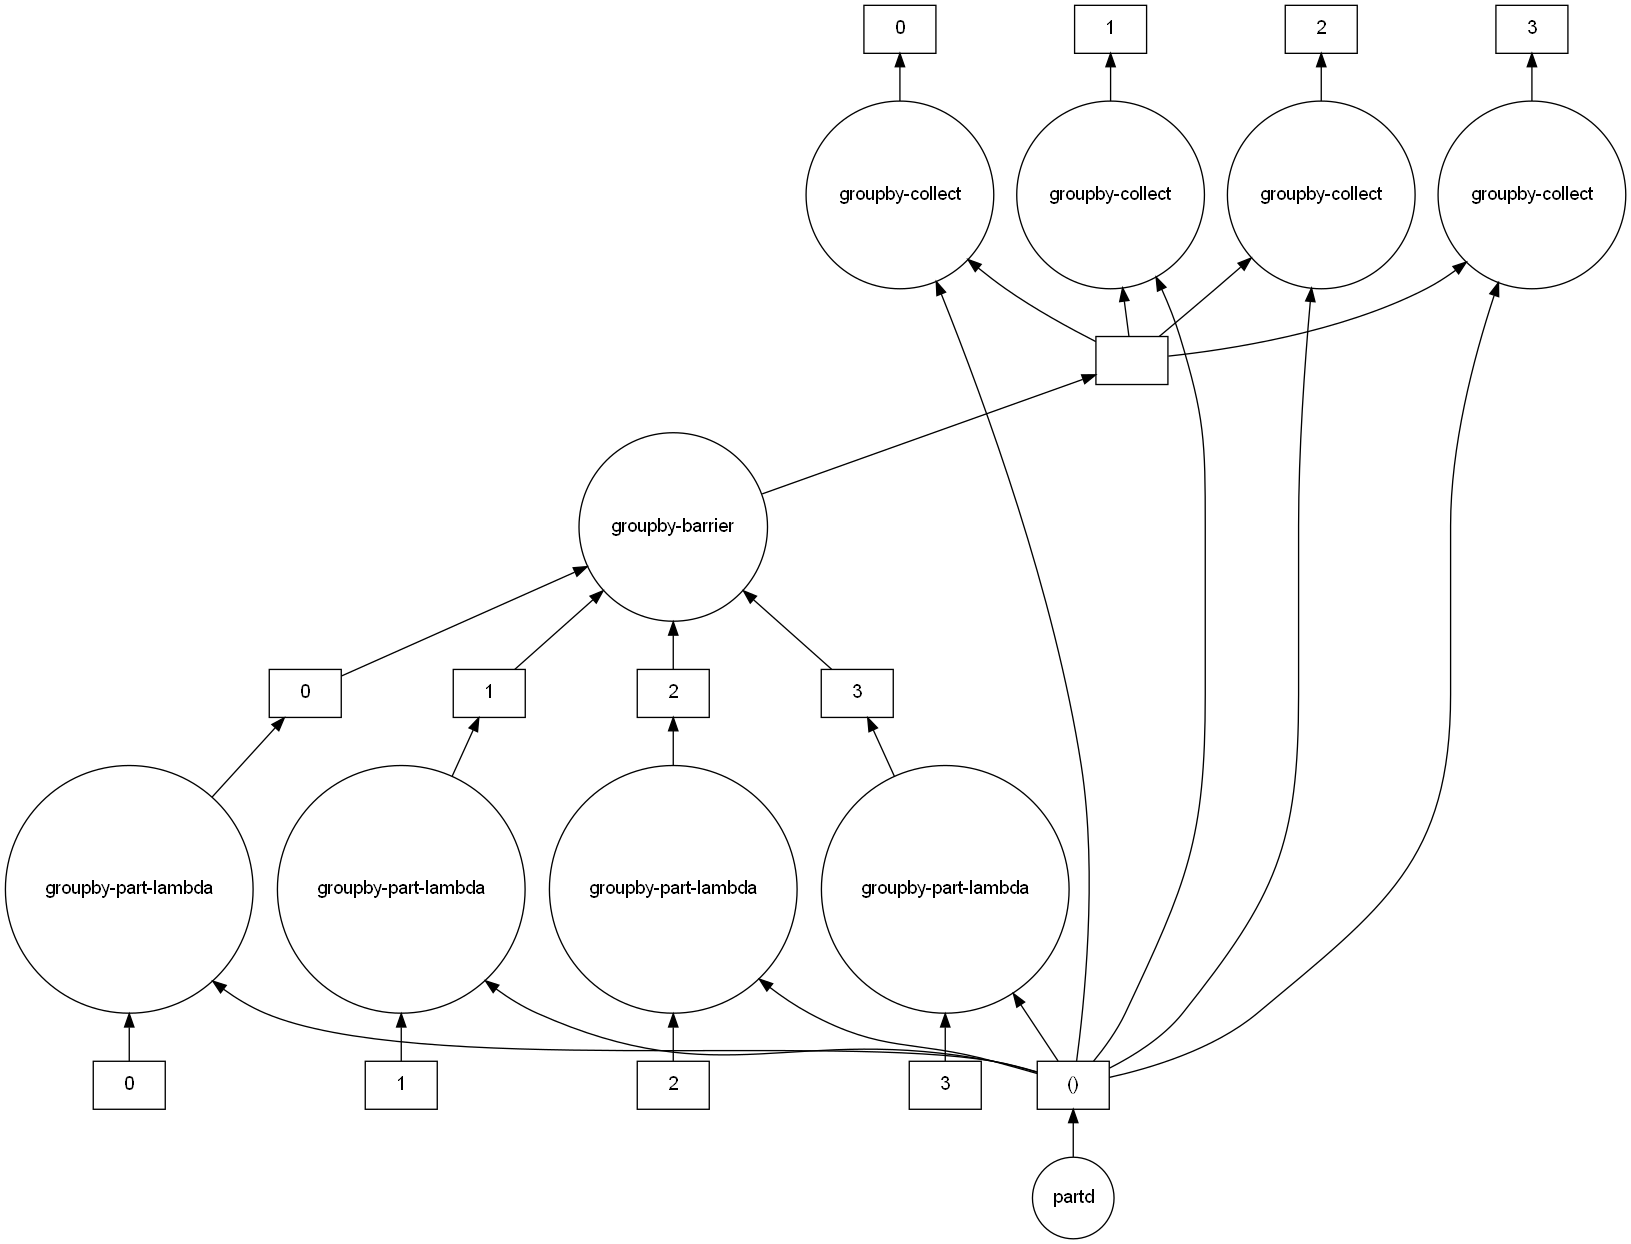

In [255]:
b = db.from_sequence(range(12), npartitions=4)
# группирует значения из bag по результатам функции key
# очень ресурсоемкая операция, по возможности нужно заменять функцие foldby, совмещающей группировку со сверткой
c = b.groupby(lambda x: x % 2 == 0)
# как это работает:
c.visualize()

In [256]:
c.compute()

[(False, [1, 3, 5, 7, 9, 11]), (True, [0, 2, 4, 6, 8, 10])]

Примеры использования функции `distinct`

In [257]:
b = db.from_sequence(['Alice', 'Bob', 'Alice'])
# возвращает уникальные значения из bag, не гарантирует упорядоченности
list(b.distinct())

['Alice', 'Bob']

In [260]:
print('Исходные данные:', names_l)
# получение bag с символами в нижнем регистре из строк в исходном списке:
symbols = db.from_sequence(names_l).str.lower().map(list).flatten()
list(symbols.distinct())

Исходные данные: ['Alice', 'Bob', 'Charlie', 'Robert']


['a', 'l', 'i', 'c', 'e', 'b', 'o', 'h', 'r', 't']

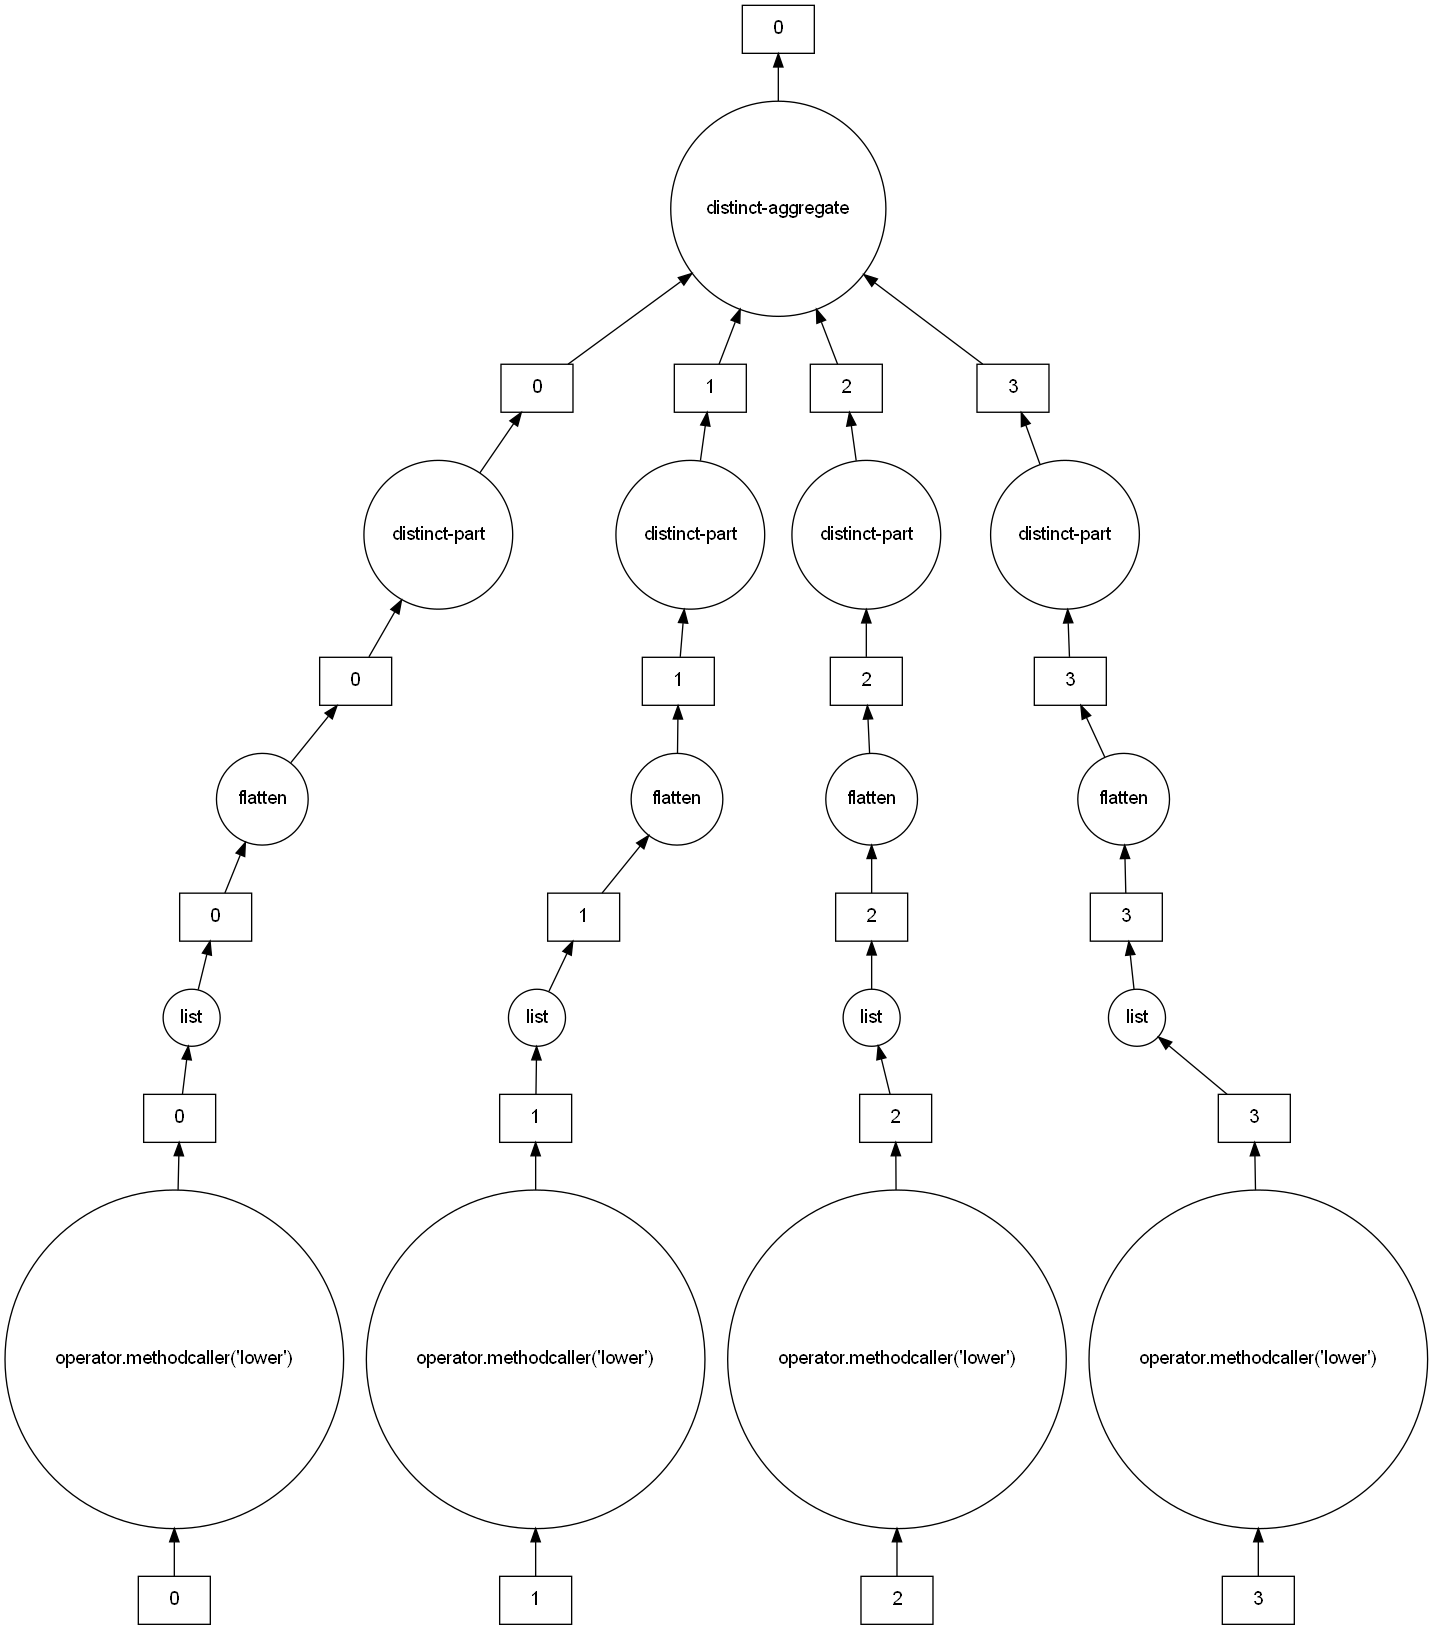

In [261]:
# как это работает:
db.from_sequence(names_l).str.lower().map(list).flatten().distinct().visualize()

Примеры использования функции `frequencies`

In [262]:
print('Исходные данные:', names_l)
# получение bag с символами в нижнем регистре из строк в исходном списке:
symbols = db.from_sequence(names_l).str.lower().map(list).flatten()
# подсчитывает частоты для элементов bag
list(symbols.frequencies())

Исходные данные: ['Alice', 'Bob', 'Charlie', 'Robert']


[('a', 2),
 ('l', 2),
 ('i', 2),
 ('c', 2),
 ('e', 3),
 ('b', 3),
 ('o', 2),
 ('h', 1),
 ('r', 3),
 ('t', 1)]

__Функции свертки__

| Функция | Краткое описание |
|------|------|
|Bag.fold(binop[, combine, initial, split_every]) | Parallelizable reduction|
|Bag.foldby(key, binop[, initial, combine, …]) | Combined reduction and groupby|
|Bag.reduction(perpartition, aggregate[, …]) | Reduce collection with reduction operators|




Работа функции `fold`:

`Bag.fold(binop, combine=None, initial='__no__default__', split_every=None, out_type=<class 'dask.bag.core.Item'>)`
* Fold похож на встроенную функцию reduce, за исключением того, что работает параллельно. 
* Fold использует две бинарные операторные функции: 
    * первую (`binop`) для выполнения свертки в каждого сегменте
    * вторую (`combine`) для объединения результатов, полученных в каждом сегменте.
    
```python
# принципиальная логика работы Bag.fold:
intermediates = [reduce(binop, part) for part in partitions]  
final = reduce(combine, intermediates)  
```
    
* Если передана только одна функция, то она используется для обеих функций binop и combine.
* Пераметр initial используется как и в обычном `reduce()`

Примеры использования функции `fold`

In [263]:
b = db.from_sequence(range(12), npartitions=4)
# fold - параллельная версия reduce, binop - бинарный оператор, используемый для свертки
b.fold(op.add).compute()

66

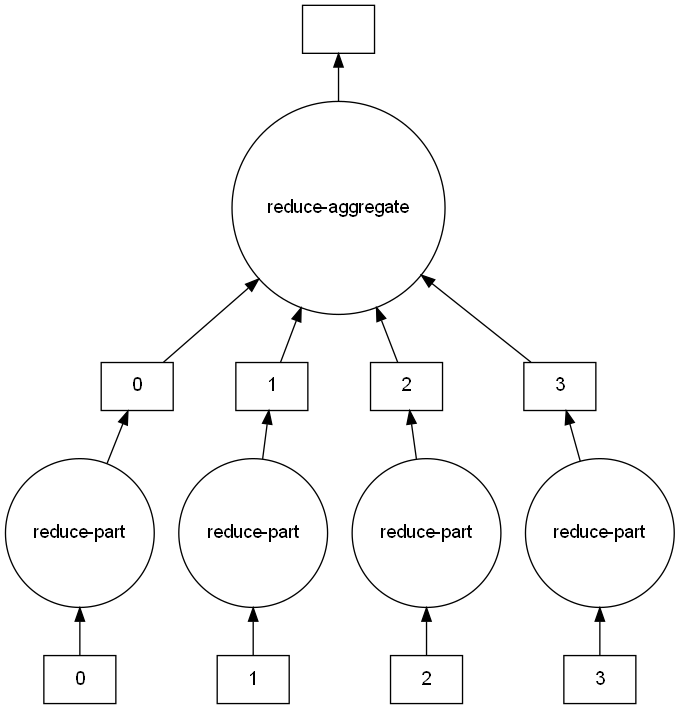

In [264]:
# как это работает:
db.from_sequence(range(12), npartitions=4).fold(op.add).visualize()

In [267]:
text = db.from_sequence('Fold is like the builtin function reduce except that it works in parallel'.split(), npartitions=4)
# bag со списками букв, содержащихся в словах
text = text.map(list)
# list(text)

In [268]:
def add_to_set(acc, x):
    return acc | set(x)

# fold может использовать две функции свертки на разных этапах операции
# первый параметр: функция для свертки на уровене сегмента; второй - для свертки результататов, полученных в сегментах
# возвращает множество всех букв, встречающихся в тексте:
print(text.fold(add_to_set, set.union, initial=set()).compute())

{'h', 'a', 'k', 'b', 'o', 'r', 'i', 'd', 'n', 'p', 'x', 'f', 's', 'u', 'e', 'c', 'l', 'w', 't', 'F'}


Примеры использования функции `foldby`

`foldby` комбинирует свертку и группировку и выполняет эту операцию намного эффективнее последовательного применения `groupby` и `reduce`.

Последовательный аналог задачи, решаемой функцией `foldby`:
```python
def reduction(group):                               
    return reduce(binop, group, init) 

b.groupby(key).map(lambda k, v: (k, reduction(v)))
```

In [269]:
b = db.from_sequence(range(400), npartitions=4)
excess_4 = lambda x: x % 4
# параметр key - опеределение ключа для группировки, binop - функция для проведения свертки
# сумма числе с соответствующими остатками при делении на 4:
list(b.foldby(excess_4, op.add))

[(0, 19800), (1, 19900), (2, 20000), (3, 20100)]

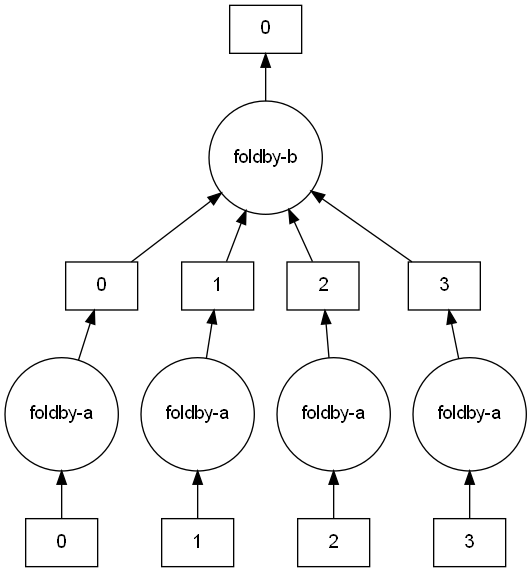

In [270]:
# как это работает:
db.from_sequence(range(400), npartitions=4).foldby(excess_4, op.add).visualize()

In [271]:
c = db.from_sequence(range(400), npartitions=4).groupby(excess_4).starmap(lambda k, v: (k, sum(v)))
c.compute()

[(0, 19800), (1, 19900), (2, 20000), (3, 20100)]

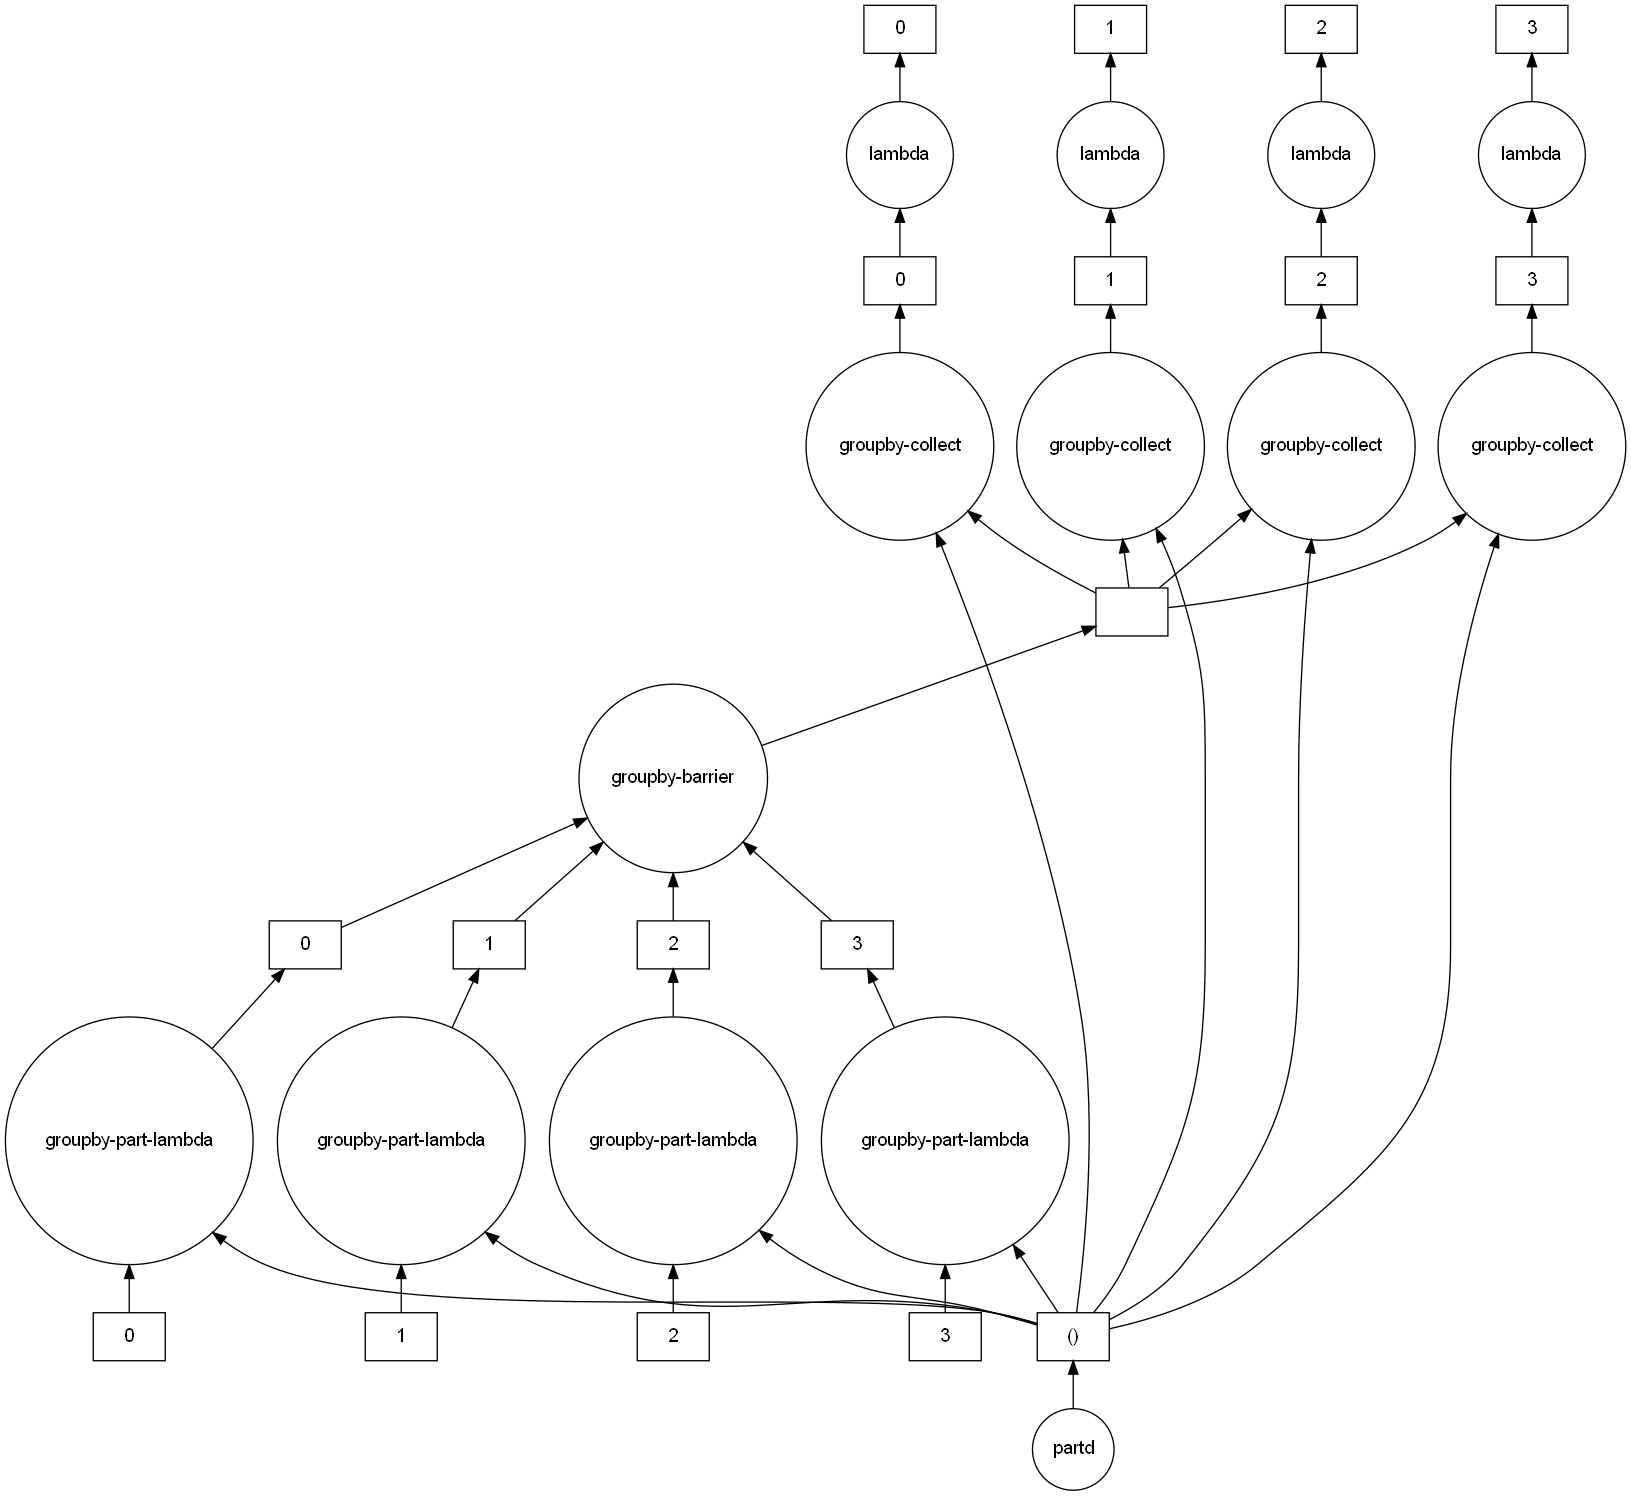

In [272]:
# как это работает:
db.from_sequence(range(40), npartitions=4).groupby(excess_4).starmap(lambda k, v: (k, sum(v))).visualize()

__Функции выполняющие агрегацию (свертку с заданными функциями)__

| Функция | Краткое описание |
|------|------|
|Bag.all([split_every]) | Are all elements truthy?|
|Bag.any([split_every]) | Are any of the elements truthy?|
|Bag.count([split_every]) | Count the number of elements|
|Bag.max([split_every]) | Maximum element|
|Bag.mean() | Arithmetic mean|
|Bag.min([split_every]) | Minimum element|
|Bag.std([ddof]) | Standard deviation|
|Bag.var([ddof])| Variance|
|Bag.sum([split_every]) | Sum all elements|

Свертка возвращающая несколько значений 

| Функция | Краткое описание |
|------|------|
|Bag.take(k[, npartitions, compute, warn])|Take the first k elements|
|Bag.topk(k[, key, split_every]) | K largest elements in collection|


Примеры использования функции `sum`

In [273]:
b = db.from_sequence(range(12), npartitions=4)
b.sum().compute()

66

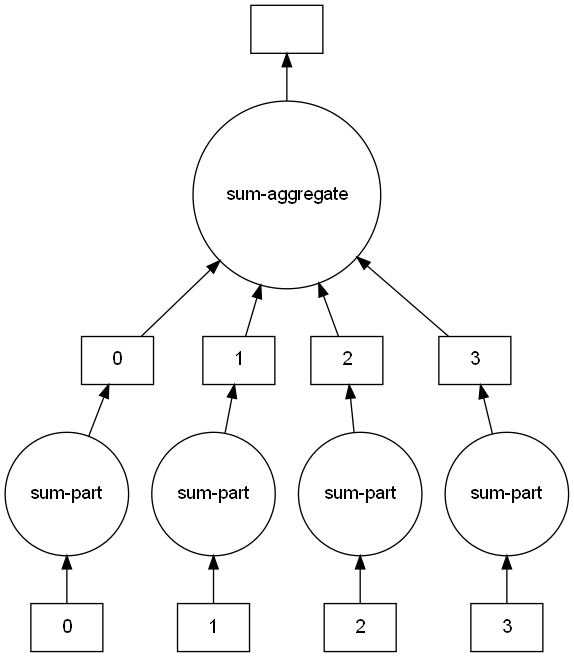

In [274]:
# как это работает:
db.from_sequence(range(12), npartitions=4).sum().visualize()

Примеры использования функции `take`

In [277]:
text = db.from_sequence('Fold is like the builtin function reduce except that it works in parallel'.split(), npartitions=2)
# возвращает первые k элементов bag
# по умолчанию значение параметра compute True, т.е. автоматически выполняются отложенные вычисления
# по умолчанию работает только с первым сегментом bag
text.str.lower().take(3)

('fold', 'is', 'like')

Примеры использования функции `topk`

In [278]:
text = db.from_sequence('Fold is like the builtin function reduce except that it works in parallel'.split())
# k наибольших значений bag
# в некоторых задачах использование функции может заменить сортировку (не реализованную для Dask Bag)
list(text.str.lower().topk(3))

['works', 'the', 'that']

In [279]:
text = db.from_sequence('Fold is like the builtin function reduce except that it works in parallel'.split())

# функция key определяет пользовательский ключ для сортировки
list(text.topk(3, key=len))

['function', 'parallel', 'builtin']

## Пример обработки данных с помощью Dask Bag <a class="anchor" id="bag_example"></a> 
-
* [к оглавлению](#разделы)

### Пример: данные о счетах в формате JSON

Автоматически генерируется фейковый набор данных JSON, сжатых с помощью gzip, в вашем каталоге данных. Он похож на данные, которые вы можете собирать из базы данных хранилища документов или веб-API.

Каждая строка в файлах представляет собой словарь в формате JSON со следующими ключами.
* id: Уникальный идентификатор клиента
* имя: Имя клиента
* транзакции: список пар «идентификатор транзакции», «сумма», по одной для каждой транзакции для клиента в этом файле.

In [ ]:
# Генерация данных (нужно создать папку ./data)
# скрипты для генерации (в т.ч. prep.py лежат в текущей папке)
%run prep.py -d accounts

In [ ]:
import os

In [280]:
filename = os.path.join('data', 'accounts.*.json.gz')
lines = db.read_text(filename)
lines.take(3)

('{"id": 0, "name": "Frank", "transactions": [{"transaction-id": 1341, "amount": 289}, {"transaction-id": 3824, "amount": 240}, {"transaction-id": 5168, "amount": 235}, {"transaction-id": 7303, "amount": 250}, {"transaction-id": 7580, "amount": 283}, {"transaction-id": 9440, "amount": 169}, {"transaction-id": 9660, "amount": 127}, {"transaction-id": 10265, "amount": 247}, {"transaction-id": 10680, "amount": 171}, {"transaction-id": 10864, "amount": 142}, {"transaction-id": 11473, "amount": 183}, {"transaction-id": 12037, "amount": 203}, {"transaction-id": 12272, "amount": 206}, {"transaction-id": 12767, "amount": 156}, {"transaction-id": 13008, "amount": 195}, {"transaction-id": 13233, "amount": 162}, {"transaction-id": 13614, "amount": 197}, {"transaction-id": 14379, "amount": 240}, {"transaction-id": 15409, "amount": 313}, {"transaction-id": 16717, "amount": 162}, {"transaction-id": 16873, "amount": 221}, {"transaction-id": 19635, "amount": 162}, {"transaction-id": 21944, "amount": 1

Наши данные загружаются из файла в виде строк текста. Обратите внимание, что распаковка файла произошла автоматически. Мы можем сделать эти данные более удобными для обработки выполнив мэппинг функцию `json.loads` для нашей структуры Dask Bag.

In [281]:
lines

dask.bag<bag-from-delayed, npartitions=50>

In [282]:
import json
js = lines.map(json.loads)
# take: inspect first few elements
js.take(3)

({'id': 0,
  'name': 'Frank',
  'transactions': [{'transaction-id': 1341, 'amount': 289},
   {'transaction-id': 3824, 'amount': 240},
   {'transaction-id': 5168, 'amount': 235},
   {'transaction-id': 7303, 'amount': 250},
   {'transaction-id': 7580, 'amount': 283},
   {'transaction-id': 9440, 'amount': 169},
   {'transaction-id': 9660, 'amount': 127},
   {'transaction-id': 10265, 'amount': 247},
   {'transaction-id': 10680, 'amount': 171},
   {'transaction-id': 10864, 'amount': 142},
   {'transaction-id': 11473, 'amount': 183},
   {'transaction-id': 12037, 'amount': 203},
   {'transaction-id': 12272, 'amount': 206},
   {'transaction-id': 12767, 'amount': 156},
   {'transaction-id': 13008, 'amount': 195},
   {'transaction-id': 13233, 'amount': 162},
   {'transaction-id': 13614, 'amount': 197},
   {'transaction-id': 14379, 'amount': 240},
   {'transaction-id': 15409, 'amount': 313},
   {'transaction-id': 16717, 'amount': 162},
   {'transaction-id': 16873, 'amount': 221},
   {'transaction

### Базовые запросы

Как только мы разберем наши данные JSON в соответствующие объекты Python (`dict`, `list` и т. д.), мы можем выполнять более интересные запросы, создавая небольшие функции Python для обработки данных.

In [283]:
# filter: keep only some elements of the sequence
js.filter(lambda record: record['name'] == 'Alice').take(5)

({'id': 12,
  'name': 'Alice',
  'transactions': [{'transaction-id': 1284, 'amount': 28},
   {'transaction-id': 2262, 'amount': 24},
   {'transaction-id': 4392, 'amount': 25},
   {'transaction-id': 4633, 'amount': 25},
   {'transaction-id': 9418, 'amount': 25},
   {'transaction-id': 9795, 'amount': 21},
   {'transaction-id': 11345, 'amount': 22},
   {'transaction-id': 11406, 'amount': 24},
   {'transaction-id': 11480, 'amount': 25},
   {'transaction-id': 12164, 'amount': 22},
   {'transaction-id': 12738, 'amount': 27},
   {'transaction-id': 13076, 'amount': 21},
   {'transaction-id': 13182, 'amount': 24},
   {'transaction-id': 14485, 'amount': 23},
   {'transaction-id': 15001, 'amount': 24},
   {'transaction-id': 17278, 'amount': 23},
   {'transaction-id': 17666, 'amount': 26},
   {'transaction-id': 18117, 'amount': 22},
   {'transaction-id': 20855, 'amount': 23},
   {'transaction-id': 21198, 'amount': 24},
   {'transaction-id': 25098, 'amount': 24},
   {'transaction-id': 27115, 'amoun

In [284]:
def count_transactions(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# применение count_transactions для всех записей Alice:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 66},
 {'name': 'Alice', 'count': 111},
 {'name': 'Alice', 'count': 53},
 {'name': 'Alice', 'count': 123},
 {'name': 'Alice', 'count': 63})

In [285]:
# pluck: выбрать значение по соответствующему ключу:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(66, 111, 53, 123, 63)

In [286]:
# Срднее количество транзакций для всех записей для Alice:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

120.71933333333334

### Использование `flatten` для обработки вложенных блоков данных

В приведенном ниже примере мы видим использование `.flatten()` для приведения вложенных данных к плоскому виду. В итогде мы вычисляем среднюю сумму по всем транзакциям для всех Alice.

In [287]:
js.filter(lambda record: record['name'] == 'Alice').pluck('transactions').take(3)

([{'transaction-id': 1284, 'amount': 28},
  {'transaction-id': 2262, 'amount': 24},
  {'transaction-id': 4392, 'amount': 25},
  {'transaction-id': 4633, 'amount': 25},
  {'transaction-id': 9418, 'amount': 25},
  {'transaction-id': 9795, 'amount': 21},
  {'transaction-id': 11345, 'amount': 22},
  {'transaction-id': 11406, 'amount': 24},
  {'transaction-id': 11480, 'amount': 25},
  {'transaction-id': 12164, 'amount': 22},
  {'transaction-id': 12738, 'amount': 27},
  {'transaction-id': 13076, 'amount': 21},
  {'transaction-id': 13182, 'amount': 24},
  {'transaction-id': 14485, 'amount': 23},
  {'transaction-id': 15001, 'amount': 24},
  {'transaction-id': 17278, 'amount': 23},
  {'transaction-id': 17666, 'amount': 26},
  {'transaction-id': 18117, 'amount': 22},
  {'transaction-id': 20855, 'amount': 23},
  {'transaction-id': 21198, 'amount': 24},
  {'transaction-id': 25098, 'amount': 24},
  {'transaction-id': 27115, 'amount': 25},
  {'transaction-id': 29519, 'amount': 22},
  {'transaction-i

In [288]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .take(3))

({'transaction-id': 1284, 'amount': 28},
 {'transaction-id': 2262, 'amount': 24},
 {'transaction-id': 4392, 'amount': 25})

In [289]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .take(3))

(28, 24, 25)

In [290]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

1392.7141634314305

### Функции Groupby и Foldby

Часто мы хотим сгруппировать данные по какой-то функции или ключу. Мы можем сделать это либо с помощью метода `.groupby`, который является простым, но требует полного перемешивания данных (дорогой операции), либо с помощью более сложного в использовании, но более быстрого метода `.foldby`, который эффективно совмещает группировку и свертку.
* `groupby`: перемешивает данные так, чтобы все элементы с одним и тем же ключом находились в одной и той же паре ключ-значение.
* `foldby`: просматривает данные, накапливая результат для каждого ключа в отдельном разделе, и агрегирует уже накопленные результы.

We find the number of people with the same name.

In [291]:
%%time
# Имейте в виду данная ячейка будет выполняться достаточно долго...
result = js.groupby(lambda item: item['name']).starmap(lambda k, v: (k, len(v))).compute()
print(sorted(result))

[('Alice', 1500), ('Bob', 836), ('Charlie', 1100), ('Dan', 700), ('Edith', 847), ('Frank', 953), ('George', 1094), ('Hannah', 1150), ('Ingrid', 700), ('Jerry', 898), ('Kevin', 1191), ('Laura', 1200), ('Michael', 745), ('Norbert', 950), ('Oliver', 500), ('Patricia', 841), ('Quinn', 900), ('Ray', 750), ('Sarah', 1100), ('Tim', 950), ('Ursula', 850), ('Victor', 848), ('Wendy', 1250), ('Xavier', 1108), ('Yvonne', 850), ('Zelda', 998)]
CPU times: total: 59.5 s
Wall time: 1min 56s


In [292]:
%%time
# Выполнение этой ячейки относительно быстро и дает тот же результат.
from operator import add
def incr(tot, _):
    return tot + 1

result = js.foldby(key='name', 
                   binop=incr, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).compute()
print(sorted(result))

[('Alice', 1500), ('Bob', 836), ('Charlie', 1100), ('Dan', 700), ('Edith', 847), ('Frank', 953), ('George', 1094), ('Hannah', 1150), ('Ingrid', 700), ('Jerry', 898), ('Kevin', 1191), ('Laura', 1200), ('Michael', 745), ('Norbert', 950), ('Oliver', 500), ('Patricia', 841), ('Quinn', 900), ('Ray', 750), ('Sarah', 1100), ('Tim', 950), ('Ursula', 850), ('Victor', 848), ('Wendy', 1250), ('Xavier', 1108), ('Yvonne', 850), ('Zelda', 998)]
CPU times: total: 391 ms
Wall time: 23.2 s
